In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
import random
from sklearn.preprocessing import MinMaxScaler
import implicit # The Cython library

# conda install -c conda-forge implicit

In [2]:
df_orders = pd.read_csv("../../DataSets Grandes/PedidosYa_Customer-Orders-11-2020.csv",sep=";")

In [3]:
df_customers = pd.read_csv("../../DataSets Grandes/Sales_Orders order 2021-01-04T2033.csv",sep=",")

# EDA

In [4]:
len(df_orders.Order_ID.unique())

74956

In [5]:
df_orders.columns = df_orders.columns.str.replace('"', '')
df_orders.rename({"\ufeffSKU_ID":"SKU_ID"},axis=1, inplace = True)

In [6]:
len(df_orders.SKU_ID.unique())

2401

In [8]:
df_orders.head(5)

,SKU_ID,Order_ID,Order_Date,Product_Name,Barcode_Array,Supplier_Names,Supplier_IDs,Listed_Unit_Price_New,Paid_Unit_Price_New,Unit_Discount,...,Total_COGS,Ordered_Quantity,Fulfilled_Quantity,Returned_Quantity,Original_Item_Subtotal,Original_Item_COGS,Adjusted_Item_Subtotal,Adjusted_Item_COGS,Store_ID,Store_Name
0,15500961,251959151,1/11/2020 00:43,Atún La Campagnola En Aceite 170 G.,"[""07793360005060"", ""7793360005060""]","LUDAJO SA,DULCENORT,VC Distribuidora SRL,Digo ...","44620,178054,25993,258156,17109,24254,37765,44...","160,00","160,00",0,...,"182,44",2,2,0.0,"320,00","182,44","320,00","182,44",163631,AR_8_Nordelta
1,15500918,251959151,1/11/2020 00:43,Azúcar Ledesma Clásica 1 Kg.,"[""07792540260138"", ""7792540260138""]","Ricardo Nini S.A.,Supermercados mayoristas Mak...","26,32","40,73","40,73",0,...,"31,29",1,1,0.0,"40,73","31,29","40,73","31,29",163631,AR_8_Nordelta
2,16953241,251959151,1/11/2020 00:43,Bolsas para residuos Asurín 50 x 70 cm. fuerte...,"[""7790117001733"", ""07790117001733""]",Supermercados mayoristas Makro SA,32,"197,82","197,82",0,...,"121,96",1,1,0.0,"197,82","121,96","197,82","121,96",163631,AR_8_Nordelta
3,18977828,251959151,1/11/2020 00:43,Choclo Amarillo Arcor Cremoso 300 G.,"[""7790580980801"", ""07790580980801""]","VC Distribuidora SRL,SFILIO ALFREDO D, GERMAN ...","17108,27502,37765,17109,25993,258182,13873,446...","57,45","57,45",0,...,"65,73",2,2,0.0,"114,91","65,73","114,91","65,73",163631,AR_8_Nordelta
4,15527698,251959151,1/11/2020 00:43,Chocolate Para Taza Águila 100 G.,"[""07790407031013"", ""7790407031013""]","LUDAJO SA,Dismarc,Canna Melis SRL,DULCENORT,TI...","44617,178054,24254,37765,24201,17108,25993,275...","136,73","136,73",0,...,"133,38",2,2,0.0,"273,45","133,38","273,45","133,38",163631,AR_8_Nordelta


In [9]:
df_customers.head(5)

,Unnamed: 0,Order Registered Date,Order ID,Salesforce ID,Restaurant Name,User ID,Confirmed Orders
0,1,29/11/2020,264553293,HKWROB,PedidosYa Market - Palermo,18997465,1
1,2,29/11/2020,264637558,45NPWL,PedidosYa Market - Boedo,17217991,1
2,3,29/11/2020,264595497,45YZX7,PedidosYa Market - Beccar,4053677,1
3,4,29/11/2020,264465290,45NPWJ,PedidosYa Market - Microcentro,16813550,1
4,5,29/11/2020,264339056,HKWROB,PedidosYa Market - Palermo,666396,1


In [7]:
df_customers = df_customers[["Order ID","User ID","Confirmed Orders"]]

In [11]:
df_orders.shape

(413584, 22)

In [12]:
df_orders.isnull().sum()

SKU_ID                      0
Order_ID                    0
Order_Date                  0
Product_Name                0
Barcode_Array               0
Supplier_Names            826
Supplier_IDs              826
Listed_Unit_Price_New       0
Paid_Unit_Price_New         0
Unit_Discount               0
Unit_Cost_New               0
Total_Amount                0
Total_COGS                  0
Ordered_Quantity            0
Fulfilled_Quantity          0
Returned_Quantity           0
Original_Item_Subtotal      0
Original_Item_COGS          0
Adjusted_Item_Subtotal      0
Adjusted_Item_COGS          0
Store_ID                    0
Store_Name                  0
dtype: int64

In [8]:
df_orders_simple = df_orders.iloc[:,[0,1,13,-2]]

In [9]:
df_orders_simple.columns

Index(['SKU_ID', 'Order_ID', 'Ordered_Quantity', 'Store_ID'], dtype='object')

In [16]:
#df_simple = df_orders.loc[:,["Order_ID", "SKU_ID", "Ordered_Quantity","Store_ID"]]

In [14]:
df_orders_simple.head(2)

,SKU_ID,Order_ID,Ordered_Quantity,Store_ID
0,15500961,251959151,2,163631
1,15500918,251959151,1,163631


In [10]:
df_full = df_orders_simple.merge(df_customers,how="inner",left_on="Order_ID",right_on="Order ID")

In [16]:
df_full.head()

,SKU_ID,Order_ID,Ordered_Quantity,Store_ID,Order ID,User ID,Confirmed Orders
0,15500961,251959151,2,163631,251959151,14988266,1
1,15500918,251959151,1,163631,251959151,14988266,1
2,16953241,251959151,1,163631,251959151,14988266,1
3,18977828,251959151,2,163631,251959151,14988266,1
4,15527698,251959151,2,163631,251959151,14988266,1


In [17]:
df_full["Confirmed Orders"].value_counts()

1    377915
0      4057
Name: Confirmed Orders, dtype: int64

In [11]:
df_full = df_full.drop(columns="Order ID")

In [12]:
df_full = df_full[df_full["Confirmed Orders"] == 1]

In [20]:
df_full.head()

,SKU_ID,Order_ID,Ordered_Quantity,Store_ID,User ID,Confirmed Orders
0,15500961,251959151,2,163631,14988266,1
1,15500918,251959151,1,163631,14988266,1
2,16953241,251959151,1,163631,14988266,1
3,18977828,251959151,2,163631,14988266,1
4,15527698,251959151,2,163631,14988266,1


In [13]:
dummies = pd.get_dummies(df_full['SKU_ID'])
df_simple_dum = df_full.drop('SKU_ID',axis = 1)

In [14]:
df_full_dummies = df_full.join(dummies)
df_full_dummies.head()

,SKU_ID,Order_ID,Ordered_Quantity,Store_ID,User ID,Confirmed Orders,15500909,15500912,15500913,15500915,...,28413649,28429849,28429931,28429932,28429933,28429934,28576439,28576441,28884458,28884461
0,15500961,251959151,2,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,15500918,251959151,1,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16953241,251959151,1,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18977828,251959151,2,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15527698,251959151,2,163631,14988266,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
df_full_dummies_reducido = df_full_dummies[:80000]

In [18]:
df_full_dummies_reducido.iloc[254,7]

1

In [19]:
test_multiply = df_full_dummies_reducido.iloc[:,6:].apply(lambda x: x*df_full_dummies_reducido["Ordered_Quantity"])

In [20]:
test_multiply.iloc[254]

15500909    0
15500912    3
15500913    0
15500915    0
15500917    0
           ..
28429934    0
28576439    0
28576441    0
28884458    0
28884461    0
Name: 254, Length: 2331, dtype: int64

In [22]:
df_final_reducido = df_full_dummies_reducido.iloc[:80000,:6].join(test_multiply)

In [23]:
df_final_reducido.drop("SKU_ID",axis=1,inplace=True)
df_final_reducido.head()

,Order_ID,Ordered_Quantity,Store_ID,User ID,Confirmed Orders,15500909,15500912,15500913,15500915,15500917,...,28413649,28429849,28429931,28429932,28429933,28429934,28576439,28576441,28884458,28884461
0,251959151,2,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,251959151,1,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,251959151,1,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,251959151,2,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,251959151,2,163631,14988266,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
df_final_reducido.drop(columns=["Ordered_Quantity","Confirmed Orders"],inplace=True)

In [25]:
df_final_reducido.columns = df_final_reducido.columns.astype(str)

In [26]:
df_final_reducido.head()

,Order_ID,Store_ID,User ID,15500909,15500912,15500913,15500915,15500917,15500918,15500920,...,28413649,28429849,28429931,28429932,28429933,28429934,28576439,28576441,28884458,28884461
0,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,251959151,163631,14988266,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,251959151,163631,14988266,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df_final_reducido.groupby(['Order_ID']).sum().head(5) #,"Store_ID"

,Store_ID,User ID,15500909,15500912,15500913,15500915,15500917,15500918,15500920,15500921,...,28413649,28429849,28429931,28429932,28429933,28429934,28576439,28576441,28884458,28884461
Order_ID,,,,,,,,,,,,,,,,,,,,,
251959151,3272620,299765320,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
251964234,492132,2628915,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
251964728,1804484,18904259,0,5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
251965286,1384362,225443151,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
251965457,1963572,206497956,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df_final_reducido_grouped = df_final_reducido.groupby(['Order_ID']).sum() #,"Store_ID"

In [29]:
df_final_reducido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80000 entries, 0 to 80838
Columns: 2334 entries, Order_ID to 28884461
dtypes: int64(2334)
memory usage: 1.4 GB


In [30]:
df_final_reducido_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12259 entries, 251959151 to 254258074
Columns: 2333 entries, Store_ID to 28884461
dtypes: int64(2333)
memory usage: 218.3 MB


## Matriz de features

In [31]:
df_final_reducido_grouped.columns.values

array(['Store_ID', 'User ID', '15500909', ..., '28576441', '28884458',
       '28884461'], dtype=object)

In [32]:
X = df_final_reducido_grouped[2:] # Esto es lo mismo que el dataframe del groupby
X2 = df_final_reducido[2:] # Sin agrupar

In [33]:
from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
X_train, X_test = train_test_split(X,test_size=0.2)
X_train2, X_test2 = train_test_split(X2,test_size=0.2)

## KMeans/PCA

In [34]:
%%time
#scaler=StandardScaler()
#X=scaler.fit_transform(data_clustering)
inertia=[]
sil=[]
ch_scores=[]
k_values=range(2,18,2)

for k in k_values:
    print(k)
    km=KMeans(n_clusters=k)
    km.fit(X)
    inertia.append(km.inertia_)   

2
4
6
8
10
12
14
16
Wall time: 3min 18s


In [35]:
inertia

[2.604534883790955e+19,
 7.544192447485198e+18,
 3.691199369503758e+18,
 2.1538646815831027e+18,
 1.4194797455489234e+18,
 9.684994208294196e+17,
 7.325051701730339e+17,
 5.448552774884519e+17]

In [36]:
k_val = range(0,2)
k_val

range(0, 2)

Text(0, 0.5, 'Inertia')

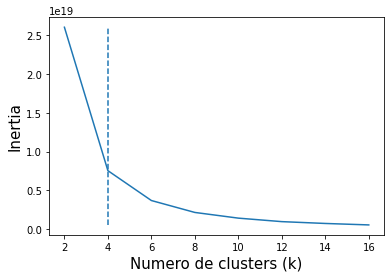

In [37]:
plt.plot(k_values,inertia);
plt.vlines(4,np.min(inertia),np.max(inertia),linestyle='dashed');
plt.xlabel('Numero de clusters (k)',fontsize=15);plt.ylabel('Inertia',fontsize='15')

# User-Item

## Baseline para recomendación

In [38]:
# Create a numeric user_id and artist_id column
df_full['User ID'] = df_full['User ID'].astype("category")
df_full['SKU_ID'] = df_full['SKU_ID'].astype("category")
df_full['User_ID_ID'] = df_full['User ID'].cat.codes
df_full['SKU_ID_ID'] = df_full['SKU_ID'].cat.codes

In [39]:
# The implicit library expects data as a item-user matrix so we
# create two matricies, one for fitting the model (item-user) 
# and one for recommendations (user-item)
#sparse_item_user = sparse.csr_matrix((df_full['Ordered_Quantity'].astype(float), (df_full['SKU_ID_ID'], df_full['User_ID_ID'])))
#sparse_user_item = sparse.csr_matrix((df_full['Ordered_Quantity'].astype(float), (df_full['User_ID_ID'], df_full['SKU_ID_ID'])))
sparse_item_user2 = sparse.csr_matrix((df_full['Confirmed Orders'].astype(float), (df_full['SKU_ID_ID'], df_full['User_ID_ID'])))
sparse_user_item2 = sparse.csr_matrix((df_full['Confirmed Orders'].astype(float), (df_full['User_ID_ID'], df_full['SKU_ID_ID'])))

## Implicit

In [41]:
import implicit

# initialize a model
model = implicit.als.AlternatingLeastSquares(factors=50, regularization=0.05)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(sparse_item_user2)

In [42]:
user_items = sparse_item_user2.T.tocsr()

In [43]:
USER=  int(input("Elija el nro de cliente:"))
CANT=  int(input("Elija la cantidad de sugerencias:"))
# recommend items for a user
recommendations = model.recommend(USER, user_items)

print ("Para el cliente especificado se encontraron los siguientes",CANT,"productos recomendados:")
print ("")
for i in np.arange(0,CANT):
    print (df_orders.Product_Name[df_orders.SKU_ID == df_full.SKU_ID.loc[df_full.SKU_ID_ID == recommendations[i][0]].iloc[0]].iloc[0], " con un ",round(recommendations[i][1]*100,2),"%"," de probable aceptación.")

Elija el nro de cliente: 240
Elija la cantidad de sugerencias: 8


Para el cliente especificado se encontraron los siguientes 8 productos recomendados:

Ojo De Bife Especial Al Vación X 800 Grs. Aprox.  con un  5.57 %  de probable aceptación.
Nalga Feteada Al Vacío X 800 Grs. Aprox.   con un  5.15 %  de probable aceptación.
Carne Picada Especial Al Vacio X 900 Grs. Aprox.  con un  4.72 %  de probable aceptación.
Entraña Al Vacío X 800 Grs. Aprox.   con un  4.63 %  de probable aceptación.
Colita De Cuadril Al Vacío X 950 Grs. Aprox.  con un  4.59 %  de probable aceptación.
Queso Holanda Tregar Unidad Aprox. 300Grs  con un  4.32 %  de probable aceptación.
Vacío Al Vacío X 800 Grs. Aprox  con un  4.07 %  de probable aceptación.
Carbón Vegetal x 4 kg.  con un  3.45 %  de probable aceptación.


In [44]:
SKU_ID_IMPLICIT=  int(input("Elija el nro deproducto:"))
# find related items
related = model.similar_items(SKU_ID_IMPLICIT)
print ("En base al producto elegido (",df_orders.Product_Name[df_orders.SKU_ID==df_full.SKU_ID.loc[df_full.SKU_ID_ID == SKU_ID_IMPLICIT].iloc[0]].values[0],"), por compras similares se encontraron los siguientes productos:")
print ("")
for i in np.arange(1,10):
    print (df_orders.Product_Name[df_orders.SKU_ID == df_full.SKU_ID.loc[df_full.SKU_ID_ID == related[i][0]].iloc[0]].iloc[0], " con un ",round(related[i][1]*100,2),"%"," de similaridad.")

Elija el nro deproducto: 320


En base al producto elegido ( Alfajorcito Jorgito Chocolate 6 U. ), por compras similares se encontraron los siguientes productos:

Alfajor Jorgito Chocolate con Dulce de Leche 55 G.  con un  68.25 %  de similaridad.
Caramelos Masticables Mogul Surtido Frutas 150 G.  con un  68.16 %  de similaridad.
Chocolate Nestle CRUNCH 22.5 G  con un  66.18 %  de similaridad.
Chocolate Para Taza Águila 100 G.  con un  66.12 %  de similaridad.
Pizza Sibarita Mozzarella x1 470 gr  con un  66.06 %  de similaridad.
Budín Limon Bonafide 200G  con un  65.81 %  de similaridad.
Chocolate Cofler Block Con Maní 38 G.  con un  65.33 %  de similaridad.
Tableta De Chocolate Milka Leger Combinado 45 G.  con un  65.22 %  de similaridad.
Oblea Bon O Bon 30 G.  con un  65.11 %  de similaridad.


## Cython

In [45]:
# Initialize the als model and fit it using the sparse item-user matrix
model2 = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)

In [46]:
# Calculate the confidence by multiplying it by our alpha value.
alpha_val = 15
#data_conf = (sparse_item_user * alpha_val).astype('double')
data_conf2 = (sparse_item_user2 * alpha_val).astype('double')

In [489]:
# Fit the model
#model.fit(data_conf)

In [47]:
# Fit the model
model2.fit(data_conf2)

In [50]:
df_orders.loc[:,["SKU_ID","Product_Name"]].sample(10)

,SKU_ID,Product_Name
268278,18977854,Galletitas Sonrisas 354 G.
104000,15791692,Gaseosa Coca Cola Sin Azúcar 500 Cc.
20725,16683321,Chocolate Shot Con Maní 35 G.
287440,15527721,Desinfectante En Aerosol Lysoform Original 360...
117041,16953224,Rapiditas light Bimbo 10 u.
331841,25703615,Queso Cheddar Feteado Finlandia Chef 150gr
185589,21109510,Carbón Vegetal x 4 kg.
46560,15607215,Jugo En Polvo Clight Naranja 7 G.
114816,16405483,Tomate Cherry X 500 g
295841,15791699,Gaseosa Schweppes tónica 1.5 l.


In [63]:
print(df_orders.loc[:,["SKU_ID","Product_Name"]][df_orders.Product_Name.str.contains("Mayonesa")])

          SKU_ID                              Product_Name
74      15527711                    Mayonesa Natura 475 G.
335     15527711                    Mayonesa Natura 475 G.
601     15527711                    Mayonesa Natura 475 G.
642     15527712  Mayonesa Hellmann's Light Doypack 475 GR
955     15527711                    Mayonesa Natura 475 G.
...          ...                                       ...
412697  15527711                    Mayonesa Natura 475 G.
412881  15527711                    Mayonesa Natura 475 G.
412882  15527711                    Mayonesa Natura 475 G.
413276  15527712  Mayonesa Hellmann's Light Doypack 475 GR
413430  15527711                    Mayonesa Natura 475 G.

[2376 rows x 2 columns]


In [51]:
SKU_ID=  int(input("Elija el nro deproducto:"))
print ("El SKU_ID del producto es el",df_full.SKU_ID.loc[df_full.SKU_ID_ID == SKU_ID].iloc[0])
print ("Eligió el producto:",df_orders.Product_Name[df_orders.SKU_ID==df_full.SKU_ID.loc[df_full.SKU_ID_ID == SKU_ID].iloc[0]].values[0])

Elija el nro deproducto: 240


El SKU_ID del producto es el 15816852
Eligió el producto: Limpiador líquido Poett lavanda 900 cc.


In [65]:
print ("SKU_ID_ID es:")
df_full.SKU_ID_ID[df_full.SKU_ID==15527711].iloc[0]

SKU_ID_ID es:


105

In [66]:
print ("SKU_ID es:")
df_full.SKU_ID.loc[df_full.SKU_ID_ID == SKU_ID].iloc[0]

SKU_ID es:


15816852

In [52]:
#---------------------
# FIND SIMILAR ITEMS
#---------------------
# Find the 10 most similar to Jay-Z (SKU-ID)
SKU_ID = 320 #Jay-Z
n_similar = 8

In [53]:
# Get the user and item vectors from our trained model
user_vecs = model.user_factors
item_vecs = model.item_factors

In [54]:
# Calculate the vector norms
item_norms = np.sqrt((item_vecs * item_vecs).sum(axis=1))

In [55]:
# Calculate the similarity score, grab the top N items and
# create a list of item-score tuples of most similar artists
scores = item_vecs.dot(item_vecs[SKU_ID]) / item_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / item_norms[SKU_ID]), key=lambda x: -x[1])

In [57]:
# Print the names of our most similar artists
items = []
for item in similar:
    idx, score = item
    items.append(df_full.SKU_ID.loc[df_full.SKU_ID_ID == idx].iloc[0])

In [58]:
print ("Para el producto -",df_orders.Product_Name[df_orders.SKU_ID==df_full.SKU_ID.loc[df_full.SKU_ID_ID == SKU_ID].iloc[0]].values[0],"- se encontraron los siguientes",n_similar,"productos sugeridos:")
print ("")
for i in np.arange(1,n_similar):
    print (df_orders.Product_Name[df_orders.SKU_ID.isin(items)].unique()[i], " con un ",round(similar[i][1]*100,2),"%"," de confianza.")

Para el producto - Alfajorcito Jorgito Chocolate 6 U. - se encontraron los siguientes 8 productos sugeridos:

Chocolate Cofler Block Con Maní 38 G.  con un  68.25 %  de confianza.
Caramelos Masticables Mogul Surtido Frutas 150 G.  con un  68.16 %  de confianza.
Pizza Sibarita Mozzarella x1 470 gr  con un  66.18 %  de confianza.
Chocolate Nestle CRUNCH 22.5 G  con un  66.12 %  de confianza.
Alfajorcito Jorgito Chocolate 6 U.  con un  66.06 %  de confianza.
Alfajor Jorgito Chocolate con Dulce de Leche 55 G.  con un  65.81 %  de confianza.
Budín Limon Bonafide 200G  con un  65.33 %  de confianza.


In [59]:
#------------------------------
# CREATE USER RECOMMENDATIONS
#------------------------------

def recommend(user_id, sparse_user_item2, user_vecs, item_vecs, num_items=10):
    """The same recommendation function we used before"""

    user_interactions = sparse_user_item2[user_id,:].toarray()

    user_interactions = user_interactions.reshape(-1) + 1
    user_interactions[user_interactions > 1] = 0

    rec_vector = user_vecs[user_id,:].dot(item_vecs.T).toarray()

    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = user_interactions * rec_vector_scaled

    item_idx = np.argsort(recommend_vector)[::-1][:num_items]

    products = []
    product_names = []
    scores = []

    for idx in item_idx:
        products.append(df_full.SKU_ID.loc[df_full.SKU_ID_ID == idx].iloc[0])
        scores.append(recommend_vector[idx])
    for item in products:
        product_names.append(df_orders.Product_Name[df_orders.SKU_ID == item].unique()[0])

    recommendations = pd.DataFrame({'product_name': product_names, 'products': products, 'score': scores})

    return recommendations

In [60]:
# Get the trained user and item vectors. We convert them to 
# csr matrices to work with our previous recommend function.
user_vecs = sparse.csr_matrix(model2.user_factors)
item_vecs = sparse.csr_matrix(model2.item_factors)

In [61]:
# Create recommendations for user with id XX
user_id = 240

recommendations = recommend(user_id, sparse_user_item2, user_vecs, item_vecs)

print (recommendations)

                                       product_name  products     score
0  Ojo De Bife Especial Al Vación X 800 Grs. Aprox.  19362522  1.000000
1               Entraña Al Vacío X 800 Grs. Aprox.   19362524  0.958308
2      Colita De Cuadril Al Vacío X 950 Grs. Aprox.  19362520  0.944627
3                   Vacío Al Vacío X 800 Grs. Aprox  19362519  0.943909
4                            Carbón Vegetal x 4 kg.  21109510  0.897804
5  Carne Picada Especial Al Vacio X 900 Grs. Aprox.  19362516  0.868862
6         Peceto Feteado Al Vacío X 800 Grs. Aprox.  19362523  0.860982
7         Nalga Feteada Al Vacío X 800 Grs. Aprox.   19362517  0.859514
8                                 Papa Blanca X 1Kg  17849054  0.849021
9                                     Cebolla X 1Kg  16405490  0.845294


## Classic KNN

In [62]:
from sklearn.cluster import KMeans

#scaler=StandardScaler()
#X_scaled=scaler.fit_transform(X);

kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10
kmeans.fit(X_train)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

In [65]:
kmeans.predict(X_train)

array([0, 0, 1, ..., 0, 0, 0])

In [67]:
X_train["Order_ID"] = X_train.index.get_level_values("Order_ID")

C:\Users\bruno\anaconda3\envs\dhdsblend37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
X_train.head(2)

,Store_ID,User ID,15500909,15500912,15500913,15500915,15500917,15500918,15500920,15500921,...,28429849,28429931,28429932,28429933,28429934,28576439,28576441,28884458,28884461,Order_ID
Order_ID,,,,,,,,,,,,,,,,,,,,,
252486211,656176,1699916,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,252486211
252546796,338166,35808646,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,252546796


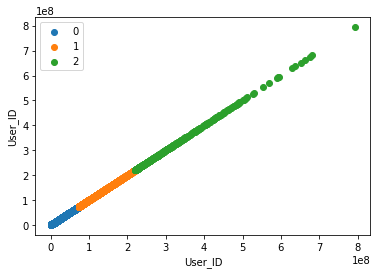

In [69]:
#predict the labels of clusters.
label = kmeans.fit_predict(X_train)

#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(X_train["User ID"][label == i] , X_train["User ID"][label == i] , label = i)
plt.xlabel("User_ID")
plt.ylabel("User_ID")
plt.legend()
plt.show()

## PCA

In [70]:
from sklearn.decomposition import PCA

In [71]:
std_sclr = StandardScaler()

In [72]:
X_train_KNN = X_train.reset_index(drop=True)

In [73]:
df_std = pd.DataFrame(std_sclr.fit_transform(X_train_KNN), index=X_train_KNN.index, columns=X_train_KNN.columns)

In [86]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(n_components=2)

In [88]:
pca_loadings = pd.DataFrame(pca.components_.T, index=X_train.columns)
pca_loadings

,0,1
Store_ID,5.317023e-03,1.764311e-01
User ID,9.999858e-01,-7.532873e-04
15500909,6.847539e-11,2.292068e-09
15500912,-4.557215e-11,2.036429e-08
15500913,4.200867e-11,-2.111491e-09
...,...,...
28576439,-0.000000e+00,0.000000e+00
28576441,-0.000000e+00,0.000000e+00
28884458,-0.000000e+00,0.000000e+00
28884461,-0.000000e+00,0.000000e+00


In [89]:
pca_loadings.T.dot(pca_loadings)

,0,1
0,1.000000e+00,5.421011e-17
1,5.421011e-17,1.000000e+00


In [92]:
df_pca = pd.DataFrame(pca.fit_transform(X_train),\
                      index=X_train.index)
df_pca.head()

,0,1
Order_ID,,
252486211,-5.775976e+07,651800.229332
252546796,-2.365319e+07,510365.105201
253854887,2.984811e+07,-728555.808523
252467835,-5.637429e+07,668843.580243
252987952,-5.084408e+07,111256.324039


In [93]:
print("Media de los CP: ")
print(X_train.mean(axis=0))

print('\n')

# Observamos la varianza de las variables:
print("Varianza de los CPs: ")
print(X_train.var(axis=0))

Media de los CP: 
Store_ID    1.028570e+06
User ID     5.945838e+07
15500909    4.456910e-02
15500912    1.118817e-01
15500913    2.315145e-02
                ...     
28576439    0.000000e+00
28576441    0.000000e+00
28884458    0.000000e+00
28884461    0.000000e+00
Order_ID    2.531709e+08
Length: 2334, dtype: float64


Varianza de los CPs: 
Store_ID    5.604064e+11
User ID     5.912380e+15
15500909    1.611101e-01
15500912    4.304637e-01
15500913    7.851332e-02
                ...     
28576439    0.000000e+00
28576441    0.000000e+00
28884458    0.000000e+00
28884461    0.000000e+00
Order_ID    4.517873e+11
Length: 2334, dtype: float64


In [94]:
pca.explained_variance_

array([5.91254734e+15, 4.53514620e+11])

In [95]:
pca.explained_variance_ratio_

array([9.99857130e-01, 7.66928028e-05])

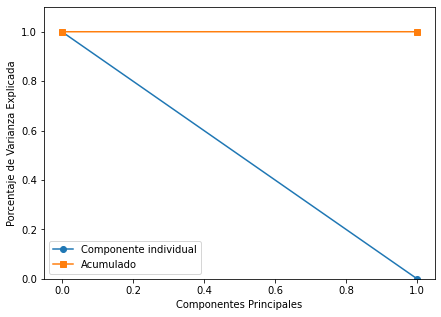

In [99]:
plt.figure(figsize=(7,5))

plt.plot(pca.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(pca.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada')
plt.xlabel('Componentes Principales')
#plt.xlim(0.75,4.25)
plt.ylim(0,1.1)
plt.legend(loc=3);

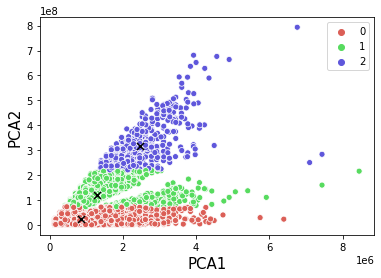

In [100]:
sns.scatterplot(x=X_train.iloc[:,0],y=X_train.iloc[:,1],hue=labels,legend='full',palette=sns.color_palette("hls", 3));
plt.xlabel('PCA1',fontsize=15);plt.ylabel('PCA2',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

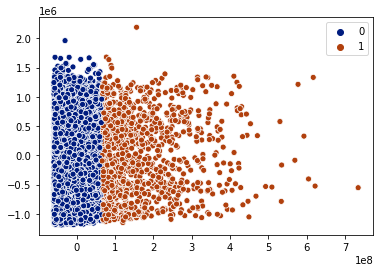

In [101]:
k=2;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X_train)

pca=PCA(n_components=2)
X_transformed=pca.fit_transform(X_train)
sns.scatterplot(X_transformed[:,0],X_transformed[:,1],hue=km.labels_,palette='dark');

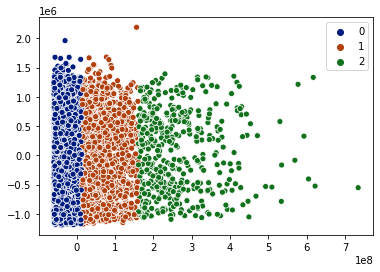

In [102]:
k=3;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X_train)

pca=PCA(n_components=2)
X_transformed=pca.fit_transform(X_train)

sns.scatterplot(X_transformed[:,0],X_transformed[:,1],hue=km.labels_,palette='dark');

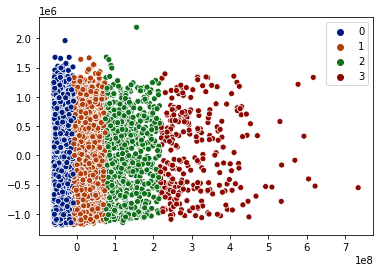

In [103]:
k=4;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X_train)

pca=PCA(n_components=2)
X_transformed=pca.fit_transform(X_train)

sns.scatterplot(X_transformed[:,0],X_transformed[:,1],hue=km.labels_,palette='dark');

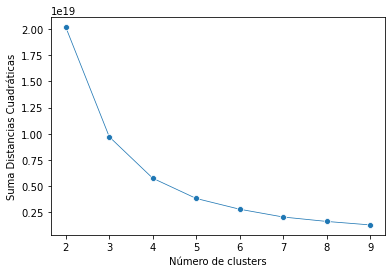

In [104]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans_sqd=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans_sqd.fit(X_train)
    sq_distances.append(kmeans_sqd.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters');    

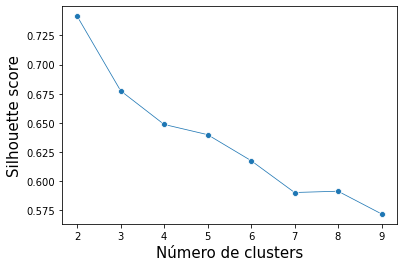

In [105]:
from sklearn.metrics import silhouette_score,silhouette_samples

sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans_sil=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans_sil.fit(X_train)
    score=silhouette_score(X_train,kmeans_sil.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

In [106]:
X_train_KNN.shape

(9805, 2334)

In [107]:
df_pca.shape

(9805, 2)

In [108]:
X_train.shape

(9805, 2334)

For n_clusters = 2 The average silhouette_score is : 0.741376513308541
For n_clusters = 3 The average silhouette_score is : 0.677514799827332
For n_clusters = 4 The average silhouette_score is : 0.6486827035255401


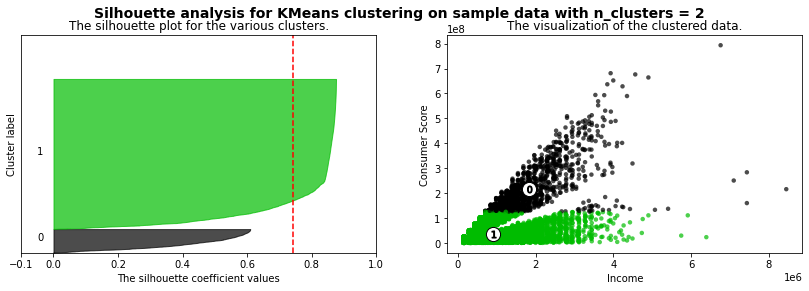

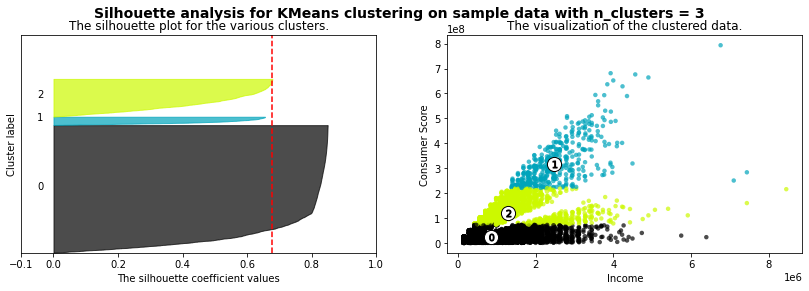

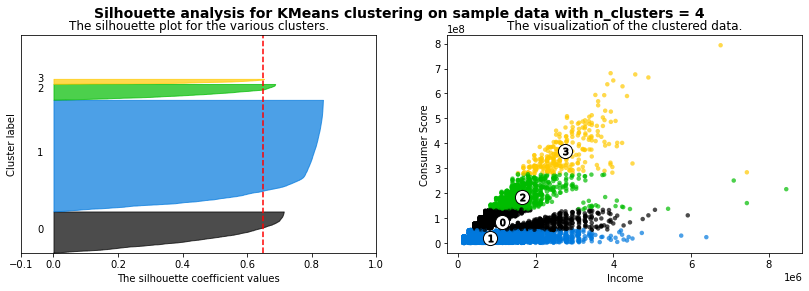

In [110]:
import matplotlib.cm as cm

for n_clusters in range(2,5):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(14, 4)
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_train, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], marker='.', s=80, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Income")
    ax2.set_ylabel("Consumer Score")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

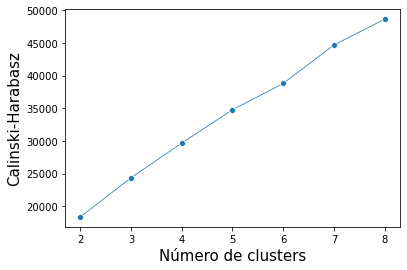

In [111]:
from sklearn.metrics import calinski_harabasz_score

k_values=range(2,9);
ch_scores=[]

for k in k_values:
    
    kmeans_ch=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans_ch.fit(X_train_KNN)
    score=calinski_harabasz_score(X_train,kmeans_ch.labels_)
    ch_scores.append(score)

sns.lineplot(x=k_values,y=ch_scores,marker='o',size=30,legend=False);
plt.ylabel('Calinski-Harabasz',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);